In [ ]:
# N antennas
# M users

In [16]:
from cvxopt import matrix, solvers
import numpy as np
import cvxpy as cp

epsilon = 0.00001

def check_feasibility(H=None, l=None, u=None, w=None, z=None, T=None):
    Hc = H[0,::] + 1j*H[1,::]
    if T is not None:
        theta = np.angle(np.matmul(Hc.conj().T, w))
        z_feasible = (np.abs(np.real(w)) <= T*z + epsilon).all() and (np.abs(np.imag(w)) <= T*z + epsilon).all()
    else:
        theta = np.angle(np.matmul(Hc.conj().T, w*z))
        z_feasible = True
    theta[theta<-epsilon] += 2*np.pi
    theta_feasible = (theta <= u + epsilon).all() and (theta >= l - epsilon).all()
    return theta_feasible and z_feasible

def qp_relaxed(H, l=None, u=None, z_mask=None, z_sol=None, max_ant=None, T=1000):
    # min  w'w
    # s.t. |H(:,m)'w|>=1, m=1,...,M
    # We assume Image(w_n)=0;
    # print(H, l,u,z_mask, z_sol, max_ant)

    assert l is not None and u is not None and z_mask is not None and z_sol is not None and max_ant is not None, "One of the arguments is None"

    _, N, M = H.shape # numeber of antennas and users, resp.
    twoN = 2*N

    mask_constr = ( (u-l)<= 2*np.pi-0.01 )
    # print('mask constraints', mask_constr)
    mask_constr[0] = False
    num_constr = sum(mask_constr) # number of inum_equality constraints l_m <= |c_m| <= u_m
    
    num_z_eq_constr = int(sum(z_mask)) + 1
    num_z_ineq_constr = N*6 + 1  # z(n)>=0, z(n)<=1, w(n)<=z(n)*M, w(n)>=-z(n)*M, z^T 1 <=L 
    
    c_dim = num_constr*2 # vector of stacked real part and imaginary part of c variable, i.e. [real(c) imag(c)]
    cw_dim = c_dim + twoN # size of w(r and i) and c with inum_eq constraints 
    cwz_dim = c_dim + twoN + N

    num_c_eq = num_constr*2 + 1
    num_eq = num_constr*2 + 1 + num_z_eq_constr # number of equality constraint c_k = h_k^H w (real and imag), 
    
    num_c_ineq = num_constr*3 + 1  
    num_ineq = num_constr*3 + num_z_ineq_constr # number of inum_equalit constraints in sin cos form
    
    Q = np.eye(cwz_dim)*2 

    Q[:c_dim, :c_dim] = 0 # since c does not appear in the objective
    Q[cw_dim:, cw_dim:] = 0 # since z does not appear in the objective

    c = np.zeros((cwz_dim,1)) # there is not linear term in the objective

    # inequality parameters
    A = np.zeros((num_ineq, cwz_dim)) 
    b = np.zeros((num_ineq, 1))

    # Equality parameters
    Aeq = np.zeros((num_eq, cwz_dim))
    beq = np.zeros((num_eq, 1))

    y_ind=0
    x_ind=0

    for m in range(1,M,1):
        if mask_constr[m] == 0:
            continue
        
        hm_real = H[0,:,m]    # 0 index is for real and 1 for imaginary
        hm_imag = H[1,:,m]
        
        Aeq[x_ind, y_ind*2] = -1  # to push c behind the equality (for the real part)
        Aeq[x_ind, c_dim:cw_dim] = np.concatenate((hm_real, hm_imag))
        
        x_ind = x_ind+1
        Aeq[x_ind, y_ind*2+1] = -1  # to push c behind the equality (for the imag part)
        Aeq[x_ind, c_dim:cw_dim] = np.concatenate((-hm_imag, hm_real))

        x_ind = x_ind + 1
        y_ind = y_ind + 1

    hm_real = H[0,:,0]
    hm_imag = H[1,:,0]

    Aeq[x_ind, c_dim:cw_dim] = np.concatenate((-hm_imag, hm_real)) # for the first element, imag(h1^H w) = 0

    # z related equality constraints:
    x_ind = num_c_eq
    for n in range(N):
        if not z_mask[n]:
            continue

        Aeq[x_ind, cw_dim+n] = 1
        beq[x_ind] = z_sol[n]
        x_ind += 1
        
    # z^T 1 == L
    Aeq[x_ind, cw_dim:cwz_dim] = 1
    beq[x_ind] = max_ant
    x_ind += 1


    t = -1
    x_ind = 0
    for m in range(1,M,1):
        if  mask_constr[m]:
            t = t + 1
        else:
            continue
        
        lx = np.cos(l[m])
        ly = np.sin(l[m])

        ux = np.cos(u[m])
        uy = np.sin(u[m])

        midx = np.cos((l[m] + u[m])/2)
        midy = np.sin((l[m] + u[m])/2)

        cc = complex((ly-uy), (lx-ux))
        
        A[x_ind , t*2] = ly - uy
        A[x_ind , t*2+1] =  -lx + ux

        b[x_ind] = (ly*ux - uy*lx)
        zr = ((cc* complex(midx, midy)) + uy*lx-ly*ux).real
        if zr > 0:
            A[x_ind,:] = -A[x_ind,:]
            b[x_ind] = -b[x_ind]

        x_ind = x_ind + 1
        
        A[x_ind , t*2] = ly
        A[x_ind , t*2+1] =  -lx
        b[x_ind] = 0
        zr = midx*ly - midy*lx
        if zr>0:
            A[x_ind,:] = -A[x_ind,:]
            b[x_ind] = -b[x_ind]
        
        x_ind = x_ind + 1

        A[x_ind , t*2] = uy
        A[x_ind , t*2+1]   =  -ux
        b[x_ind] = 0
        zr = midx*uy - midy*ux

        if zr>0:
            A[x_ind,:] = -A[x_ind,:]
            b[x_ind] = -b[x_ind]
        
        x_ind = x_ind + 1


    A[x_ind, c_dim:cw_dim] = np.concatenate((-hm_real,-hm_imag))
    b[x_ind] = -1

    # inequality constraints related to z variable
    x_ind = num_c_ineq
    for n in range(N):
        # z(n) >= 0
        # print('x_ind {}, y_ind {}'.format(x_ind, n+cw_dim))
        A[x_ind, n+cw_dim] = -1
        x_ind += 1
        
        # z(n) <= 1
        A[x_ind, n+cw_dim] = 1
        b[x_ind] = 1
        x_ind += 1
        
        # w(n) <= z(n)*M
        A[x_ind, n+c_dim] = 1    # real(w(n))
        A[x_ind, n+cw_dim] = -T
        x_ind += 1
        
        # w(n) <= z(n)*M
        A[x_ind, n+N+c_dim] = 1  # imag(w(n))
        A[x_ind, n+cw_dim] = -T
        x_ind += 1

        # w(n) >= -z(n)*M
        A[x_ind, n+c_dim] = -1   # real(w(n))
        A[x_ind, n+cw_dim] = -T
        x_ind += 1
        
        # w(n) >= -z(n)*M
        A[x_ind, n+N+c_dim] = -1 # imag(w(n))
        A[x_ind, n+cw_dim] = -T
        x_ind += 1

    # z^T 1 <= L
#     A[x_ind, cw_dim:cwz_dim] = 1
#     b[x_ind] = max_ant
#     x_ind += 1

    # optnew = optimset('Display','off','LargeScale','off');

    Q   = matrix(Q)
    c   = matrix(c)
    A   = matrix(A)
    b   = matrix(b)
    Aeq = matrix(Aeq)
    beq = matrix(beq)
    # print("A", A)
    # print("b", b)
    solvers.options['show_progress'] = False
    solution = solvers.qp(Q,c,A,b,Aeq,beq)
    # print('the status of relaxed solver is ', solution['status'])

    wz = np.array(solution['x'][c_dim:])
    w = wz[:N] + wz[N:2*N]*1j
    z = wz[2*N:]

    optimal = False
    is_feasible = False
    if solution['status'] == 'optimal':
        optimal = True
        is_feasible = True # automatically holds
    else:
        # check feasibility
        is_feasible = check_feasibility(H=H, l=l, u=u, w=w.squeeze(), z=z.squeeze(), T=T)
        optimal = is_feasible # TODO: Optimality may need to be verified by running the cvxpy version. 
        
    # print(solution['y'])

    # return z.squeeze(), w.squeeze(), np.array(solution['primal objective']), optimal
    return z.squeeze(), w.squeeze(), np.linalg.norm(w.squeeze(), 2)**2, optimal

def qp_relaxed_with_selected_antennas(H, l=None, u=None, z_sol=None, M=1000):

    _, N, M = H.shape # numeber of antennas and users, resp.
    assert sum(z_sol) >= 1, "No antenna selected"

    twoN = 2*N

    mask_constr = ( (u-l)<= 2*np.pi-0.01 )
    mask_constr[0] = False
    num_constr = sum(mask_constr) # number of inum_equality constraints l_m <= |c_m| <= u_m
    
    c_dim = num_constr*2 # vector of stacked real part and imaginary part of c variable, i.e. [real(c) imag(c)]
    cw_dim = c_dim + twoN # size of w(r and i) and c with inum_eq constraints 

    num_eq = num_constr*2 + 1 # number of equality constraint c_k = h_k^H w (real and imag), 
    
    num_ineq = num_constr*3 + 1  # number of inum_equalit constraints in sin cos form
    
    Q = np.eye(cw_dim)*2 

    # mask the objective
    # for i in range(N):
    #     if not z_sol[i]:
    #         Q[c_dim+i,c_dim+i] = 0
    #         Q[c_dim+N+i,c_dim+N+i] = 0        


    Q[:c_dim, :c_dim] = 0 # since c does not appear in the objective

    c = np.zeros((cw_dim,1)) # there is not linear term in the objective

    # inequality parameters
    A = np.zeros((num_ineq, cw_dim)) 
    b = np.zeros((num_ineq, 1))

    # Equality parameters
    Aeq = np.zeros((num_eq, cw_dim))
    beq = np.zeros((num_eq, 1))

    y_ind=0
    x_ind=0

    for m in range(1,M,1):
        if mask_constr[m] == 0:
            continue
        
        hm_real = H[0,:,m]*z_sol.squeeze()    # 0 index is for real and 1 for imaginary
        hm_imag = H[1,:,m]*z_sol.squeeze()
        
        Aeq[x_ind, y_ind*2] = -1  # to push c behind the equality (for the real part)
        Aeq[x_ind, c_dim:cw_dim] = np.concatenate((hm_real, hm_imag))
        
        x_ind = x_ind+1
        Aeq[x_ind, y_ind*2+1] = -1  # to push c behind the equality (for the imag part)
        Aeq[x_ind, c_dim:cw_dim] = np.concatenate((-hm_imag, hm_real))

        x_ind = x_ind + 1
        y_ind = y_ind + 1

    # print('shapes', z_sol.shape, H[0,:,0].shape)
    hm_real = H[0,:,0]*z_sol.squeeze()
    hm_imag = H[1,:,0]*z_sol.squeeze()

    Aeq[x_ind, c_dim:cw_dim] = np.concatenate((-hm_imag, hm_real)) # for the first element, imag(h1^H w) = 0


    t = -1
    x_ind = 0
    for m in range(1,M,1):
        if  mask_constr[m]:
            t = t + 1
        else:
            continue
        
        lx = np.cos(l[m])
        ly = np.sin(l[m])

        ux = np.cos(u[m])
        uy = np.sin(u[m])

        midx = np.cos((l[m] + u[m])/2)
        midy = np.sin((l[m] + u[m])/2)

        cc = complex((ly-uy), (lx-ux))
        
        A[x_ind , t*2] = ly - uy
        A[x_ind , t*2+1] =  -lx + ux

        b[x_ind] = (ly*ux - uy*lx)
        zr = ((cc* complex(midx, midy)) + uy*lx-ly*ux).real
        if zr > 0:
            A[x_ind,:] = -A[x_ind,:]
            b[x_ind] = -b[x_ind]

        x_ind = x_ind + 1
        
        A[x_ind , t*2] = ly
        A[x_ind , t*2+1] =  -lx
        b[x_ind] = 0
        zr = midx*ly - midy*lx
        if zr>0:
            A[x_ind,:] = -A[x_ind,:]
            b[x_ind] = -b[x_ind]
        
        x_ind = x_ind + 1

        A[x_ind , t*2] = uy
        A[x_ind , t*2+1]   =  -ux
        b[x_ind] = 0
        zr = midx*uy - midy*ux

        if zr>0:
            A[x_ind,:] = -A[x_ind,:]
            b[x_ind] = -b[x_ind]
        
        x_ind = x_ind + 1


    A[x_ind, c_dim:cw_dim] = np.concatenate((-hm_real,-hm_imag))
    b[x_ind] = -1

    Q   = matrix(Q)
    c   = matrix(c)
    A   = matrix(A)
    b   = matrix(b)
    Aeq = matrix(Aeq)
    beq = matrix(beq)
    # print("A", A)
    # print("b", b)
    solvers.options['show_progress'] = False
    solution = solvers.qp(Q,c,A,b,Aeq,beq)
    wz = np.array(solution['x'][c_dim:])
    w = wz[:N] + wz[N:2*N]*1j

    optimal = False
    is_feasible = False
    if solution['status'] == 'optimal':
        optimal = True
        is_feasible = True # automatically holds
    else:
        # check feasibility
        is_feasible = check_feasibility(H=H, l=l, u=u, w=w.squeeze(), z=z_sol.squeeze(), T=None)
        print('feasible')
        if is_feasible:
            w_cp, obj_cp, opt_cp = cvxpy_relaxed_with_selected_antennas(H,l=l,u=u, z_sol=z_sol.squeeze())
        optimal = is_feasible # TODO: Optimality may need to be verified by running the cvxpy version. 
        if optimal:
            w = w_cp.copy()
            
    # z = wz[2*N:]
    # print(solution['y'])
    # return w.squeeze(),  np.array(solution['primal objective']), optimal
    return w.squeeze(),  np.linalg.norm(w.squeeze(), 2)**2, optimal


def cvxpy_relaxed(H, l=None, u=None, z_mask=None, z_sol=None, max_ant=None, T=1000):
    # l of shape M-1, u of shape M-1
    _,N,M = H.shape
    
    H = H[0,::] + 1j*H[1,::]
    w = cp.Variable(N, complex=True)
    c = cp.Variable(M-1, complex=True)
    z = cp.Variable(N)
    
    obj = cp.Minimize(cp.square(cp.norm(w, 2)))
    constraints = []

    # Equality Constraints
    constraints += [c == H[:,1:].conj().T @ w]
    
    # Inequality Constraints
    constraints += [cp.real(H[:,0].conj().T @ w) >= 1]
    constraints += [cp.imag(H[:,0].conj().T @ w) == 0]
    
    l = l[1:].copy()
    u = u[1:].copy()
    mask = (u-l)<=np.pi
    # print(mask)
    constraints += [cp.multiply(np.sin(l)*mask, cp.real(c)) - cp.multiply(np.cos(l)*mask, cp.imag(c)) <= np.zeros(M-1)]
    constraints += [cp.multiply(np.sin(u)*mask, cp.real(c)) - cp.multiply(np.cos(u)*mask, cp.imag(c)) >= np.zeros(M-1)]
    
    constraints += [cp.real(w[:]) <=  T*z]
    constraints += [cp.real(w[:]) >= -T*z]
    constraints += [cp.imag(w[:]) <=  T*z]
    constraints += [cp.imag(w[:]) >= -T*z]
    
#     one = np.ones(N)
    # constraints += [cp.sum(z)<=max_ant]

    # Enforce maximum antenna constraint
    constraints += [cp.sum(z) == max_ant]

    for n in range(N):
        if z_mask[n]:
            constraints += [z[n] == z_sol[n]]
    
    constraints += [z >= np.zeros(N), z <= np.ones(N)]
    
    a = (np.cos(l) + np.cos(u))/2 
    b = (np.sin(l) + np.sin(u))/2
    constraints += [cp.multiply(cp.multiply(a,cp.real(c)) + cp.multiply(b, cp.imag(c)), mask) >= cp.multiply(a**2 +b**2,mask)]

    prob = cp.Problem(obj, constraints)
    prob.solve(verbose=False)
    
    optimal = True
    if w.value is None:
        optimal = False
        return np.zeros(N), np.zeros(N), np.inf, optimal
    return z.value.squeeze(), w.value.squeeze(), np.linalg.norm(w.value.squeeze(),2)**2, optimal


def cvxpy_relaxed_with_selected_antennas(H, l=None, u=None, z_sol=None, M=1000):
    """
    cvxpy implementation of qp_relaxed_with_selected_antennas
    """
    # l of shape M-1, u of shape M-1
    _,N,M = H.shape
    
    H = H[0,::] + 1j*H[1,::]
    w = cp.Variable(N, complex=True)
    c = cp.Variable(M-1, complex=True)
    
    obj = cp.Minimize(cp.square(cp.norm(w, 2)))
    constraints = []

    # Equality Constraints
    constraints += [c == H[:,1:].conj().T @ cp.multiply(w, z_sol)]
    
    # Inequality Constraints
    constraints += [cp.real(H[:,0].conj().T @ cp.multiply(w, z_sol)) >= 1]
    constraints += [cp.imag(H[:,0].conj().T @ cp.multiply(w, z_sol)) == 0]
    
    l = l[1:].copy()
    u = u[1:].copy()
    mask = (u-l)<=np.pi

    constraints += [cp.multiply(np.sin(l)*mask, cp.real(c)) - cp.multiply(np.cos(l)*mask, cp.imag(c)) <= np.zeros(M-1)]
    constraints += [cp.multiply(np.sin(u)*mask, cp.real(c)) - cp.multiply(np.cos(u)*mask, cp.imag(c)) >= np.zeros(M-1)]
    
    a = (np.cos(l) + np.cos(u))/2 
    b = (np.sin(l) + np.sin(u))/2
    constraints += [cp.multiply(cp.multiply(a,cp.real(c)) + cp.multiply(b, cp.imag(c)), mask) >= cp.multiply(a**2 +b**2,mask)]

    prob = cp.Problem(obj, constraints)
    prob.solve(verbose=False)
    
    optimal = True
    if w.value is None:
        optimal = False
        return np.zeros(N), np.inf, optimal
    return w.value.squeeze(), np.linalg.norm(w.value.squeeze(),2)**2, optimal


# if __name__=='__main__':
#     N = 12
#     M = 6
#     H = np.random.randn(2, N, M)

#     z_sol = np.random.binomial(size=N, n=1, p= 0.5)
#     z_mask = np.random.binomial(size=N, n=1, p=0.6)

#     # H = np.array([[[ 1.27109919,  0.62238554],
#     #             [-0.38933997,  0.48843181],
#     #             [-0.14073963, -0.77918651]],

#     #             [[-1.40115267, -0.17910412],
#     #             [-0.82520195, -1.08825745],
#     #             [-0.62317508, -0.67931762]]])
#     l = np.zeros(M)
#     u = np.random.rand(M)*np.pi
#     import time
#     t1 = time.time()
#     w,z,obj,opt = solve_relaxed(H, l, u, z_mask, z_sol)
#     print('time taken {}'.format(time.time()-t1))
#     print(w,z,obj)

In [17]:
z_mask = np.array([1., 1., 1., 1.])
z_sol = np.array([1., 1., 1., 0.]) 
l = np.array([0.        , 0.        , 4.71238898, 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.57079633, 0.        ])
u = np.array([6.28318531, 6.28318531, 6.28318531, 4.71238898, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       3.14159265, 6.28318531])

pl = np.array([0.         ,0.         , 4.71238898,  3.14159265 , 0.,         0.,
 0.,         0.,         0.,          0.,         0.,         0.        ])
pu = u.copy()

H = np.array([[[ 1.22847877,   1.2610585 ,  -1.07593312,  0.57751775, -0.92501821,
    0.33330266,   1.22979361,  -2.0750823 ,  0.79921747,  1.3176018,
   -0.95963159,   0.07271868, ],
  [ 1.03231077,  -0.49025626,   0.88511541,  0.21608628, -0.5632059,
    0.36680924,   0.71043538,  -1.17607352, -0.60210294, -0.42387011,
   -0.86356223,  -0.13362889, ],
  [-0.63064218,   1.88071933,  -1.366563  , -1.40048759,  1.11487286,
   -0.31258144,   0.38881077,  -1.12912491, -0.27428637,  2.03026232,
    1.35366173,   0.51371231, ],
  [ 0.18330437,  -0.80134932,  -0.47593308, -1.01627841,  0.21895807,
   -0.28866487,  -0.38559825,  -0.96656761, -1.33348992,  0.02455812,
   -0.44067888,  -0.51072645, ]],
 [[ 0.93142038,   0.56729974,  -0.78691001, -0.99889031, -0.02639658,
    1.51063731,  -1.48365265,  -0.26268162, -0.04185223,  1.3886523,
   -0.25607246,  -0.8136744 , ],
  [-0.47829562,  -0.25244409,  -0.6650412 , -0.64133846,  1.14683478,
    0.32430479,  -0.71982796,   0.34842448,  0.74362681,  0.08925087,
    0.04117055,   0.51038322, ],
  [ 0.15152388,   0.49522714,   1.74818206, -1.34904132, -1.96277277,
    0.54134301,   0.35830898,   0.25930624,  0.31675316,  1.29771661,
    0.74618068,   0.10688285, ],
  [-0.52334906,   0.06097788,  -0.13800276, -1.96651673,  0.85040749,
    0.3116803 ,   1.44266852,   0.67605472, -0.56189268, -0.73151394,
    0.43858782,   0.33346117, ]]])



In [18]:
w_ant, obj_ant, opt_ant = qp_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_sol)
w_ant_cp, obj_ant_cp, opt_ant_cp = cvxpy_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_sol)

w_ant_p, obj_ant_p, opt_ant_p = qp_relaxed_with_selected_antennas(H, l=pl, u=pu, z_sol=z_sol)
w_ant_cp_p, obj_ant_cp_p, opt_ant_cp_p = cvxpy_relaxed_with_selected_antennas(H, l=pl, u=pu, z_sol=z_sol)



feasible


In [19]:
obj_ant

0.6711144436103736

In [20]:
obj_ant_p

0.6615405323050726

In [21]:
obj_ant_cp

0.6711142189871516

In [22]:
obj_ant_cp_p

0.6615405323050726

In [9]:
N =12
M = 4

for i in range(1000):
    print('example {}'.format(i))
    H = np.random.randn(2, N, M)

    z_constr = np.random.binomial(size=N, n=1, p=0.6)
    max_ant = int(sum(z_constr))
    z_mask = np.random.binomial(size=N, n=1, p=0.4)

    # H = np.array([[[ 1.27109919,  0.62238554],
    #             [-0.38933997,  0.48843181],
    #             [-0.14073963, -0.77918651]],

    #             [[-1.40115267, -0.17910412],
    #             [-0.82520195, -1.08825745],
    #             [-0.62317508, -0.67931762]]])

    # H[:,2,:] = 0
    # H[:,10,:] = 0
    # H[:,0,:] = 0
    # H[:,11,:] = 0

    l = np.zeros(M)
    u = np.random.rand(M)*np.pi
    import time
    t1 = time.time()

    z,w, obj, opt = qp_relaxed(H, l=l, u=u, z_sol=z_constr, z_mask=z_mask, max_ant=max_ant)
#     print('qp r', time.time()-t1)
    t1 = time.time()

    z_cp, w_cp, obj_cp, opt_cp = cvxpy_relaxed(H, l=l, u=u, z_sol=z_constr, z_mask=z_mask, max_ant=max_ant)
#     print('cp r', time.time()-t1)
    t1 = time.time()

    w_ant, obj_ant, opt_ant = qp_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_constr)
#     print('qp', time.time()-t1)
    t1 = time.time()

    w_ant_cp, obj_ant_cp, opt_ant_cp = cvxpy_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_constr)
#     print('cp', time.time()-t1)
    
    assert opt == opt_cp and opt_ant == opt_ant_cp, "returned different values"
    assert np.abs(obj-obj_cp) < 0.001 and np.abs(obj_ant-obj_ant_cp) < 0.001, 'different objective values'

    
# w,z,obj,opt = solve_relaxed(H, l, u, z_mask, z_constr)
print('time taken {}'.format(time.time()-t1))

print()
print('relaxed:', obj, opt)
print('relaxed cp:', obj_cp, opt_cp)
print()
print('selected ants:',  obj_ant, opt_ant)
print('selected ants from cp:', obj_ant_cp, opt_ant_cp)


example 0
example 1
example 2
example 3
example 4
example 5
example 6
example 7
example 8
example 9
example 10
example 11
example 12
example 13
example 14
example 15
example 16
example 17
example 18
example 19
example 20
example 21
example 22
example 23
example 24
example 25
example 26
example 27
example 28
example 29
example 30
example 31
example 32
example 33
example 34
example 35
example 36
example 37
example 38
example 39
example 40
example 41
example 42
example 43
example 44
example 45
example 46
example 47
example 48
example 49
example 50
example 51
example 52
example 53
example 54
example 55
example 56
example 57
example 58
example 59
example 60
example 61
example 62
example 63
example 64
example 65
example 66
example 67
example 68
example 69
example 70
example 71
example 72
example 73
example 74
example 75
example 76
example 77
example 78
example 79
example 80
example 81
example 82
example 83
example 84
example 85
example 86
example 87
example 88
example 89
example 90
example 9

KeyboardInterrupt: 

In [4]:
obj

0.2159860243293438

In [5]:
obj_cp

0.2159860540494366

In [8]:
np.abs(obj-obj_cp)

2.9720092803442455e-08

In [232]:

w_ant, obj_ant, opt_ant = solve_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_constr)
#     print('qp', time.time()-t1)
t1 = time.time()

w_ant_cp, obj_ant_cp, opt_ant_cp = cvxpy_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_constr)
#     print('cp', time.time()-t1)
print('selected ants:',  obj_ant, opt_ant)
print('selected ants from cp:', obj_ant_cp, opt_ant_cp)


checking feasibility
feasiblity False
selected ants: 5861.290385418716 False
selected ants from cp: 5861.307316305347 True


In [219]:
opt_cp

True

In [220]:
opt_ant

False

In [221]:
opt_ant_cp

True

In [237]:
Hc = H[0,::] + 1j*H[1,::]
theta = np.angle(np.matmul(Hc.conj().T, w_ant*z_constr))
theta[theta<-0.000001] += 2*np.pi
print(theta <= u + 0.0001)
print(theta >= l - 0.0001)



[ True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True]


In [238]:
w_ant

array([  0.         +0.j        ,  23.83214148+12.2753663j ,
       -12.98037149 -6.10227818j,   5.95012794 +4.91102455j,
       -28.49883224 -3.49651362j,   0.         +0.j        ,
         0.         +0.j        , -34.29987716+15.68638013j,
       -20.17063472-46.11065507j,   0.         +0.j        ,
         0.         +0.j        ,  -9.6060497  -2.26018235j])

In [236]:
z_constr

array([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [239]:
w_ant_cp

array([ -0.         +0.j        ,  23.83217572+12.27538393j,
       -12.98039064 -6.10228741j,   5.95013636 +4.91103154j,
       -28.49887354 -3.49651857j,  -0.         +0.j        ,
        -0.         +0.j        , -34.29992692+15.68640298j,
       -20.17066373-46.11072134j,  -0.         +0.j        ,
        -0.         +0.j        ,  -9.60606384 -2.26018575j])

In [226]:
z_constr

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [211]:
np.abs(np.real(w)) <= T*z + 0.00001
np.abs(np.imag(w)) <= T*z + 0.00001


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [207]:
T= 1000

In [206]:
np.imag(w)

array([-4.11863307e-01,  3.55509683e-02,  1.28739178e-15,  1.55878435e-15,
       -2.48931778e-16,  4.52601466e-01,  2.89637828e-01, -6.02370130e-01,
        4.16008665e-01, -3.04138250e-01,  8.22258613e-16, -1.68662533e-01])

In [195]:
opt

False

In [193]:
w_cp

array([-0.        +0.j        , -0.        +0.j        ,
       -0.4024479 +1.09546194j,  0.29325017-0.87130448j,
       -0.        +0.j        , -0.6268739 -1.84174073j,
       -0.        +0.j        , -0.        +0.j        ,
       -0.        +0.j        , -0.03960923+1.58457109j,
       -0.89495712+0.13918701j, -0.        +0.j        ])

In [194]:
opt_cp

True

In [160]:
(theta <= u + 0.0001).all() and (theta >= l - 0.0001).all()
# print(theta >= l - 0.0001)

True

In [196]:
z

array([-9.20070841e-31, -8.90579040e-31,  1.00000000e+00,  4.66466816e-03,
        1.70298939e-31,  1.00000000e+00,  3.10464528e-31, -1.49714665e-30,
       -1.97825497e-30,  5.18837998e-03,  4.76104061e-03,  3.76988805e-31])

In [197]:
w

array([ 5.89524158e-14-1.25587698e-14j,  8.55185695e-14-5.53343897e-15j,
       -4.02447874e-01+1.09546217e+00j,  2.93250304e-01-8.71304411e-01j,
       -6.86962170e-14-7.87795875e-14j, -6.26873701e-01-1.84174064e+00j,
       -3.79371339e-13+1.48823546e-14j,  3.40560283e-14+6.14722422e-14j,
        7.08369352e-14-8.67522281e-14j, -3.96089650e-02+1.58457092e+00j,
       -8.94957145e-01+1.39186801e-01j, -5.49516497e-14-8.16883782e-14j])

In [167]:
Hc = H[0,::] + 1j*H[1,::]
theta = np.angle(np.matmul(Hc.conj().T, w*z))
theta[theta<-0.000001] += 2*np.pi
print((theta <= u + 0.0001).all() and (theta >= l - 0.0001).all())


True


In [100]:
u

array([0.01222672, 0.03424164, 1.3967591 , 2.10793577, 2.24349769,
       2.46760919, 1.4528189 , 1.38978275, 1.61270782, 1.68896829,
       2.71319201, 2.53972947])

In [102]:
2*np.pi

6.283185307179586

In [81]:
theta > l

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [79]:
u

array([2.69119934, 0.11799235, 0.27315536, 0.43236966, 2.74794577,
       2.21908712, 2.14931188, 3.09668187, 3.02737189, 0.27515492,
       1.77440592, 2.25718556])

In [58]:
l

array([0., 0., 0.])

In [59]:
u

array([0.97211068, 1.38725743, 2.63140159])

In [411]:
N = 12
M = 6
H = np.random.randn(2, N, M)

z_constr = np.random.binomial(size=N, n=1, p= 0.5)
z_mask = np.random.binomial(size=N, n=1, p=0.6)

# H = np.array([[[ 1.27109919,  0.62238554],
#             [-0.38933997,  0.48843181],
#             [-0.14073963, -0.77918651]],

#             [[-1.40115267, -0.17910412],
#             [-0.82520195, -1.08825745],
#             [-0.62317508, -0.67931762]]])
l = np.zeros(M)
u = np.random.rand(M)*np.pi
import time
t1 = time.time()
w,z,obj,opt = solve_relaxed(H, l, u, z_mask, z_constr)
print('time taken {}'.format(time.time()-t1))
w,z,obj

x_ind 16, y_ind 34
x_ind 22, y_ind 35
x_ind 28, y_ind 36
x_ind 34, y_ind 37
x_ind 40, y_ind 38
x_ind 46, y_ind 39
x_ind 52, y_ind 40
x_ind 58, y_ind 41
x_ind 64, y_ind 42
x_ind 70, y_ind 43
x_ind 76, y_ind 44
x_ind 82, y_ind 45
time taken 0.012542724609375


(array([[ 7.19505223e-13+3.29704567e-13j],
        [ 1.21027810e-02-6.87078779e-02j],
        [-4.28424080e-02-2.77601490e-02j],
        [-6.62001637e-02+6.64786068e-02j],
        [-1.11749780e-01+6.76550301e-02j],
        [ 2.91521545e-13+4.38638783e-13j],
        [-4.39103204e-14-6.72171666e-13j],
        [ 2.13791827e-01-9.65347563e-02j],
        [ 1.08150612e-01+8.11907927e-02j],
        [ 1.91725858e-13-2.89003022e-13j],
        [-1.34819790e-01+9.24306268e-02j],
        [-6.33147960e-02-5.58644015e-03j]]),
 array([[-5.17454300e-28],
        [ 3.37948889e-01],
        [ 1.00000000e+00],
        [ 1.00000000e+00],
        [ 3.36528507e-01],
        [-1.39290797e-27],
        [-6.00039352e-28],
        [ 3.39868863e-01],
        [ 3.40337064e-01],
        [-3.05504380e-28],
        [ 3.36625382e-01],
        [ 3.35786059e-01]]),
 array(0.1374146))

In [412]:
t1 = time.time()
w,z,obj = cvxpy_relaxed(H, l, u, z_mask, z_constr)
print('time taken {}'.format(time.time()-t1))

w,z,obj

[ True  True  True  True  True]
(12,)
time taken 0.10188031196594238


(array([-0.        +0.j        ,  0.01210234-0.06870795j,
        -0.04284228-0.02776012j, -0.06620032+0.06647876j,
        -0.11174991+0.06765476j, -0.        +0.j        ,
        -0.        +0.j        ,  0.21379208-0.09653459j,
         0.10815093+0.08119062j, -0.        +0.j        ,
        -0.13481972+0.09243079j, -0.06331457-0.00558626j]),
 array([-0.,  1.,  1.,  1.,  1., -0., -0.,  1.,  1., -0.,  1.,  1.]),
 0.1374147216042721)

In [413]:
z_constr = np.random.binomial(size=N, n=1, p= 0.1)
z_mask = np.random.binomial(size=N, n=1, p=0.9)

w,z,obj,opt = solve_relaxed(H, l, u, z_mask, z_constr)
w,z,obj

x_ind 16, y_ind 34
x_ind 22, y_ind 35
x_ind 28, y_ind 36
x_ind 34, y_ind 37
x_ind 40, y_ind 38
x_ind 46, y_ind 39
x_ind 52, y_ind 40
x_ind 58, y_ind 41
x_ind 64, y_ind 42
x_ind 70, y_ind 43
x_ind 76, y_ind 44
x_ind 82, y_ind 45


(array([[ 0.01754389+0.06489238j],
        [-0.03627506-0.08285251j],
        [ 0.00306147-0.06823316j],
        [-0.08285696+0.08283039j],
        [-0.08286275+0.08284589j],
        [ 0.08285035+0.08284713j],
        [-0.08284986-0.08286294j],
        [ 0.08285026-0.08279338j],
        [ 0.08286158+0.08114181j],
        [ 0.08286115-0.05195472j],
        [-0.08285212+0.08286143j],
        [-0.08285804-0.08131345j]]),
 array([[ 6.02297691e-08],
        [-4.55116677e-08],
        [-2.79850161e-08],
        [ 3.23168729e-07],
        [ 5.08396676e-07],
        [-2.03410849e-07],
        [ 8.80218762e-08],
        [-3.75355994e-07],
        [-8.00097136e-09],
        [ 3.00464701e-08],
        [-1.27447856e-08],
        [-1.60043409e-07]]),
 array(0.13622041))

In [414]:
print(solve_qp_relaxed(H,l,u))

(array([[ 0.017827  +0.02469714j],
       [ 0.00518497-0.07171324j],
       [-0.03935158-0.01120249j],
       [-0.05344584+0.06095952j],
       [-0.10054412+0.06696613j],
       [ 0.03781318+0.06225304j],
       [-0.07211956-0.03121264j],
       [ 0.18393998-0.08676232j],
       [ 0.10927758+0.07042291j],
       [ 0.02480157-0.02202991j],
       [-0.09580431+0.08149193j],
       [-0.06852238-0.0117019j ]]), array(0.12043298), True)


In [278]:
z_sol

array([1, 0, 0, 0, 0])

In [2]:
N =4
M = 3
H = np.random.randn(2, N, M)

z_constr = np.random.binomial(size=N, n=1, p=0.5)
max_ant = int(sum(z_constr))
z_mask = np.random.binomial(size=N, n=1, p=1)

# H = np.array([[[ 1.27109919,  0.62238554],
#             [-0.38933997,  0.48843181],
#             [-0.14073963, -0.77918651]],

#             [[-1.40115267, -0.17910412],
#             [-0.82520195, -1.08825745],
#             [-0.62317508, -0.67931762]]])

# H[:,2,:] = 0
# H[:,10,:] = 0
# H[:,0,:] = 0
# H[:,11,:] = 0

l = np.zeros(M)
u = np.random.rand(M)*np.pi
import time
t1 = time.time()

z,w,obj,obj_sys,opt = solve_relaxed(H, l=l, u=u, z_sol=z_constr, z_mask=z_mask, max_ant=max_ant)
w_ant,obj_ant,opt_ant = solve_relaxed_with_selected_antennas(H, l=l, u=u, z_sol=z_constr, M=1000)

# w,z,obj,opt = solve_relaxed(H, l, u, z_mask, z_constr)
print('time taken {}'.format(time.time()-t1))
print('relaxed:', w,obj)
print('selected ants:', w_ant,obj_ant)

ValueError: not enough values to unpack (expected 5, got 4)

In [48]:
N = 6
M = 4
max_ant = 3

Hc = [[ 0.62571781+2.72415222j, -0.54101919-0.45843073j, -0.44805802+1.27683149j,  -0.46125053+1.00847479j],
      [-1.59781347+0.296329j  , -0.58914722+0.20805462j,  2.21904677+0.26475457j,   0.36392105-2.91403817j],
      [-1.60135047-0.98651348j,  0.89603928-1.40551393j,  1.05375387+2.14074207j,   0.99508891-0.2327909j ],
      [ 1.26936525-0.48679647j, -0.25508431-0.13168349j,  1.16945902-1.00926596j,  -1.53611364-1.18201692j],
      [-0.486522  +0.0631393j , -0.83414479-1.7454618j,   0.03252856+2.09824549j,  -0.5796956 +0.13906341j],
      [ 1.34389894+2.81860267j, -0.92533614-1.66570825j, -0.31683803+0.19832999j,  -0.24084493+0.25068606j]]
H = np.stack((np.real(Hc),np.imag(Hc)))

p_zmask = np.array([1, 1, 1, 1, 1, 0])
p_zsol = np.array([0, 1, 1, 0, 0, 0.00147334])

c_zmask = np.array([1, 1, 1, 1, 1, 1])
c_zsol = np.array([0, 1, 1, 0, 0, 0])

c_zmask = np.array([0., 0., 0., 0., 1., 0.])
c_zsol = np.array([0, 1, 1, 0, 0, 0])

p_l = np.array([0.        , 3.14159265, 0.        , 3.14159265])
p_u = np.array([6.28318531, 6.28318531, 1.57079633, 4.7123])
c_l = np.array([0.        , 3.14159265, 0.        , 3.14159265])
c_u = np.array([6.28318531, 6.28318531, 1.57079633, 3.92699082])

w_ant,obj_ant,opt_ant = solve_relaxed_with_selected_antennas(H, l=c_l, u=c_u, z_sol=c_zsol)

z,w,obj,obj_sys,opt = solve_relaxed(H, l=c_l, u=c_u, z_sol=c_zsol, z_mask=c_zmask, max_ant=max_ant)

print(obj_ant, opt_ant)
print(obj, opt)


print('*******************')

z, w, obj = cvxpy_relaxed(H, l=c_l, u=c_u, z_sol=c_zsol, z_mask=c_zmask, max_ant=max_ant)

     pcost       dcost       gap    pres   dres
 0:  1.1296e-02  4.7554e+00  2e+01  4e+00  7e+00
 1:  4.9700e-01  8.0299e+00  7e+00  2e+00  3e+00
 2:  3.2275e-01  5.1470e+01  9e+00  2e+00  3e+00
 3:  3.4245e-01  4.4783e+02  2e+01  2e+00  3e+00
 4:  3.6210e-01  1.0311e+04  1e+02  2e+00  2e+00
 5:  3.6877e-01  9.7852e+05  9e+02  2e+00  2e+00
 6:  3.6944e-01  1.0318e+09  2e+04  2e+00  2e+00
Terminated (singular KKT matrix).
solution status with antennas unknown
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.    -1.     0.     0.     0.     0.     0. -1000.     0.
     0.     0.     0.     0.]
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.    -1.     0.     0.     0.     0.     0. -1000.
     0.     0.     0.     0.]
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.    -1.     0.     0.     0.     0.     0.
 -1000.     0.     0.     0.]
[    0.     0.     0.

  Primal.  obj: 1.0853207298e-01    nrm: 2e+02    Viol.  con: 2e-08    var: 2e-08    cones: 0e+00  
  Dual.    obj: 1.0853206588e-01    nrm: 4e+02    Viol.  con: 0e+00    var: 6e-11    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 01 11:20:51 AM: Problem status: optimal
(CVXPY) Mar 01 11:20:51 AM: Optimal value: 1.085e-01
(CVXPY) Mar 01 11:20:51 AM: Compilation took 5.214e-02 seconds
(CVXPY) Mar 01 11:20:51 AM: Solver (including time spent in interface) took 6.063e-02 seconds
(6,)


In [8]:
from solve_relaxation import solve_relaxed
import numpy as np
N = 6
M = 4
max_ant = 5

H = [[[-1.74976547,  0.3426804,   1.1530358,  -0.25243604],
      [ 0.98132079,  0.51421884,  0.22117967, -1.07004333],
      [-0.18949583,  0.25500144, -0.45802699,  0.43516349],
      [-0.58359505,  0.81684707,  0.67272081, -0.10441114],
      [-0.53128038,  1.02973269, -0.43813562, -1.11831825],
      [ 1.61898166,  1.54160517, -0.25187914, -0.84243574]],

     [[ 0.18451869,  0.9370822,   0.73100034,  1.36155613],
      [-0.32623806,  0.05567601,  0.22239961, -1.443217  ],
      [-0.75635231,  0.81645401,  0.75044476, -0.45594693],
      [ 1.18962227, -1.69061683, -1.35639905, -1.23243451],
      [-0.54443916, -0.66817174,  0.00731456, -0.61293874],
      [ 1.29974807, -1.73309562, -0.9833101,   0.35750775]]]

H = np.array(H)
# z_sol = np.array([0.16241392, 0.16099165, 0.16067969, 0.16145474, 0.        , 0.16317441])
z_mask = np.array([0., 0., 0., 0., 1., 0.])
z_sol = np.array([0.00163732, 0.00161734, 0.00161329, 0.00162343, 0.        ,0.00164673])
l = np.array([0., 0., 0., 0.])
u = np.array([6.28318531, 6.28318531, 6.28318531, 3.14159265])

# for i in range(5):
z,w,obj,opt = solve_relaxed(H, l=l, u=u, z_sol=z_sol, z_mask=z_mask, max_ant=max_ant)
z,w,obj = cvxpy_relaxed(H, l=l, u=u, z_sol=z_sol, z_mask=z_mask, max_ant=max_ant)

print(z,w,obj,opt)

[[[-1.74976547  0.3426804   1.1530358  -0.25243604]
  [ 0.98132079  0.51421884  0.22117967 -1.07004333]
  [-0.18949583  0.25500144 -0.45802699  0.43516349]
  [-0.58359505  0.81684707  0.67272081 -0.10441114]
  [-0.53128038  1.02973269 -0.43813562 -1.11831825]
  [ 1.61898166  1.54160517 -0.25187914 -0.84243574]]

 [[ 0.18451869  0.9370822   0.73100034  1.36155613]
  [-0.32623806  0.05567601  0.22239961 -1.443217  ]
  [-0.75635231  0.81645401  0.75044476 -0.45594693]
  [ 1.18962227 -1.69061683 -1.35639905 -1.23243451]
  [-0.54443916 -0.66817174  0.00731456 -0.61293874]
  [ 1.29974807 -1.73309562 -0.9833101   0.35750775]]] [0. 0. 0. 0.] [6.28318531 6.28318531 6.28318531 3.14159265] [0. 0. 0. 0. 1. 0.] [0.00163732 0.00161734 0.00161329 0.00162343 0.         0.00164673] 5
mask constraints [False False False  True]
     pcost       dcost       gap    pres   dres
 0:  4.8397e-02 -3.3538e+01  3e+02  1e+00  6e+04
 1:  3.5874e-01 -2.0897e+01  3e+01  8e-02  3e+03
 2:  2.2587e-01 -7.0219e-01  1e+0

(6,)
[ 1.  1.  1.  1. -0.  1.] [-0.16142719+0.01702287j  0.09053325-0.03009766j -0.01748213-0.0697783j
 -0.0538402 +0.10975028j -0.        +0.j          0.14936137+0.11991j   ] 0.09225640821466599 True


In [9]:
obj

0.09225640821466599

In [57]:
     pcost       dcost       gap    pres   dres
 0:  4.8397e-02 -3.3538e+01  3e+02  1e+00  6e+04
 1:  3.5874e-01 -2.0897e+01  3e+01  4e-01  3e+03
 2:  2.2587e-01 -7.0219e-01  1e+00  3e-01  1e+02
 3:  1.1240e-01  1.7306e-02  1e-01  2e+00  8e+00
 4:  9.3310e-02  8.7825e-02  6e-03  5e-01  1e-01
 5:  9.2287e-02  9.1794e-02  5e-04  3e-01  3e-03
 6:  9.2256e-02  9.2243e-02  1e-05  2e-01  4e-05
 7:  9.2256e-02  9.2256e-02  1e-07  3e-01  4e-07
 8:  9.2256e-02  9.2256e-02  1e-09  6e-01  4e-09
 9:  9.2256e-02  9.2256e-02  1e-11  7e-03  4e-11
10:  9.2256e-02  9.2256e-02  1e-13  9e-02  4e-12
11:  9.2256e-02  9.2256e-02  1e-15  3e-01  9e-14
12:  9.2256e-02  9.2256e-02  1e-17  2e-02  4e-14

[[[-1.74976547  0.3426804   1.1530358  -0.25243604]
  [ 0.98132079  0.51421884  0.22117967 -1.07004333]
  [-0.18949583  0.25500144 -0.45802699  0.43516349]
  [-0.58359505  0.81684707  0.67272081 -0.10441114]
  [-0.53128038  1.02973269 -0.43813562 -1.11831825]
  [ 1.61898166  1.54160517 -0.25187914 -0.84243574]]

 [[ 0.18451869  0.9370822   0.73100034  1.36155613]
  [-0.32623806  0.05567601  0.22239961 -1.443217  ]
  [-0.75635231  0.81645401  0.75044476 -0.45594693]
  [ 1.18962227 -1.69061683 -1.35639905 -1.23243451]
  [-0.54443916 -0.66817174  0.00731456 -0.61293874]
  [ 1.29974807 -1.73309562 -0.9833101   0.35750775]]] [0. 0. 0. 0.] [6.28318531 6.28318531 6.28318531 3.14159265] [0. 0. 0. 0. 1. 0.] [0.00163732 0.00161734 0.00161329 0.00162343 0.         0.00164673] 5

array([ 1.72205483e-03,  1.69730494e-03,  1.72866778e-03,  1.73877628e-03,
       -8.41480089e-32,  1.75929973e-03])

In [59]:
opt

True

In [1]:
from bb import *
np.random.seed(seed = 100)
N = 6
M = 4
max_ant = 5

u_avg = 0
t_avg = 0
tstep_avg = 0
for i in range(1):
    H = np.random.randn(N, M) + 1j*np.random.randn(N,M)    
    instance = np.stack((np.real(H), np.imag(H)), axis=0)
    _, global_U, timesteps, t, ub_list, lb_list = solve_bb(instance, max_ant=max_ant, max_iter = 7000)
    u_avg += global_U
    t_avg += t
    tstep_avg += timesteps

print(u_avg, t_avg, tstep_avg, u_avg)

# print('bb solution: {}, optimal: {}'.format(global_U, optimal_f) )


[[[-1.74976547  0.3426804   1.1530358  -0.25243604]
  [ 0.98132079  0.51421884  0.22117967 -1.07004333]
  [-0.18949583  0.25500144 -0.45802699  0.43516349]
  [-0.58359505  0.81684707  0.67272081 -0.10441114]
  [-0.53128038  1.02973269 -0.43813562 -1.11831825]
  [ 1.61898166  1.54160517 -0.25187914 -0.84243574]]

 [[ 0.18451869  0.9370822   0.73100034  1.36155613]
  [-0.32623806  0.05567601  0.22239961 -1.443217  ]
  [-0.75635231  0.81645401  0.75044476 -0.45594693]
  [ 1.18962227 -1.69061683 -1.35639905 -1.23243451]
  [-0.54443916 -0.66817174  0.00731456 -0.61293874]
  [ 1.29974807 -1.73309562 -0.9833101   0.35750775]]] [0. 0. 0. 0.] [6.28318531 6.28318531 6.28318531 6.28318531] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] 5
beginning z [0.00163732 0.00161734 0.00161329 0.00162343 0.001613   0.00164673]
shape s (6,) (6,)
timestep 0 1.4602124251398083 0.0875807867066967 1
branching var value 6.283185307179586
(4, 3)


NameError: name 'N' is not defined

In [2]:

from bb import *

def solve_bb(instance, max_ant=5, max_iter=10000, policy='default', policy_type='gnn', oracle_opt=None):
    t1 = time.time()
    if policy_type == 'default':
        env = BBenv(observation_function=Observation, epsilon=0.001)
    elif policy_type == 'gnn':
        env = BBenv(observation_function=Observation, epsilon=0.001)
    elif policy_type == 'linear':
        env = BBenv(observation_function=LinearObservation, epsilon=0.001)
    elif policy_type == 'oracle':
        env = BBenv(observation_function=Observation, epsilon=0.001)
        pass

    branching_policy = DefaultBranchingPolicy()

    t1 = time.time()

    env.reset(instance, max_ant=max_ant)
    timestep = 0
    done = False
    ub_list = []
    lb_list = []
    while timestep < max_iter and len(env.nodes)>0 and not done:
        print('timestep', timestep, env.global_U, env.global_L, len(env.nodes))
        env.fathom_nodes()
        if len(env.nodes) == 0:
            break
        node_id, node_feats, label = env.select_node()
        
        if len(env.nodes) == 0:
            break
        # prune_node = env.prune(node_feats)
        # if prune_node:
        #     env.delete_node(node_id)
        #     continue
        # else:
        branching_var = branching_policy.select_variable(node_feats, env.action_set_indices, env=env)
        print(branching_var)
        print('selected node z_sol {}, z_mask {}, z_feas {}'.format(env.nodes[node_id].z_sol, env.nodes[node_id].z_mask, env.nodes[node_id].z_feas))

        done = env.push_children(branching_var, node_id)
        timestep = timestep+1

        if env.is_terminal():
            break
        ub_list.append(env.global_U)
        lb_list.append(env.global_L)


    print('ended')
    print('result', env.z_incumbent.copy(), np.linalg.norm(env.w_incumbent,2)**2)
    # returns the solution, objective value, timestep and the time taken
    return env.z_incumbent.copy(), env.global_U, timestep , time.time()-t1, ub_list, lb_list

In [3]:

np.random.seed(seed = 100)
N = 6
M = 12
max_ant = 3

u_avg = 0
t_avg = 0
tstep_avg = 0
for i in range(1):
    H = np.random.randn(N, M) + 1j*np.random.randn(N,M)    
    instance = np.stack((np.real(H), np.imag(H)), axis=0)
    z_inc, global_U, timesteps, t, ub_list, lb_list = solve_bb(instance, max_ant=max_ant, max_iter = 7000)
    u_avg += global_U
    t_avg += t
    tstep_avg += timesteps

print(u_avg, t_avg, tstep_avg, u_avg)

[[[-1.74976547  0.3426804   1.1530358  -0.25243604  0.98132079
    0.51421884  0.22117967 -1.07004333 -0.18949583  0.25500144
   -0.45802699  0.43516349]
  [-0.58359505  0.81684707  0.67272081 -0.10441114 -0.53128038
    1.02973269 -0.43813562 -1.11831825  1.61898166  1.54160517
   -0.25187914 -0.84243574]
  [ 0.18451869  0.9370822   0.73100034  1.36155613 -0.32623806
    0.05567601  0.22239961 -1.443217   -0.75635231  0.81645401
    0.75044476 -0.45594693]
  [ 1.18962227 -1.69061683 -1.35639905 -1.23243451 -0.54443916
   -0.66817174  0.00731456 -0.61293874  1.29974807 -1.73309562
   -0.9833101   0.35750775]
  [-1.6135785   1.47071387 -1.1880176  -0.54974619 -0.94004616
   -0.82793236  0.10886347  0.50780959 -0.86222735  1.24946974
   -0.07961125 -0.88973148]
  [-0.88179839  0.01863895  0.23784462  0.01354855 -1.6355294
   -1.04420988  0.61303888  0.73620521  1.02692144 -1.43219061
   -1.8411883   0.36609323]]

 [[-0.33177714 -0.68921798  2.03460756 -0.55071441  0.75045333
   -1.306992

before [0. 0. 1. 1. 1. 0.] [ 0.34743892  0.32081474  1.          1.         -0.          0.33174635]
after [0. 0. 1. 1. 1. 0.] [ 0.34743892  0.32081474  1.          1.         -0.          0.33174635]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  1.         1.         0.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.36359565  0.31566327  1.          1.         -0.          0.32074108]
after [0. 0. 1. 1. 1. 0.] [ 0.36359565  0.31566327  1.          1.         -0.          0.32074108]
timestep 5 1.6871634067683483 0.12346565365086319 16
branching var value 6.283185307179586
(2, 3)
selected node z_sol [0.00160057 0.0015809  0.00157324 0.00158578 0.         0.001594  ], z_mask [0. 0. 0. 0. 1. 0.], z_feas [1. 1. 0. 0. 0. 1.]
solving relaxed with z_mask [0. 0. 1. 0. 1. 0.], z_sol [0.00160057 0.0015809  0.         0.00158578 0.         0.001594  ]
before [0. 0. 1. 0. 1. 0.] [ 0.74550761  0.74115463 -0.          0.73619936 -0.          0.7771384 ]
after [0.

after [1. 1. 1. 1. 1. 1.] [ 1. -0. -0.  1. -0.  1.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         1.         0.         0.001594  ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [0. 0. 1. 1. 1. 0.] [0.00160057 0.0015809  0.         1.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14

before [0. 0. 1. 1. 1. 0.] [ 0.65921127  0.65624464  1.         -0.         -0.          0.68454409]
after [0. 0. 1. 1. 1. 0.] [ 0.65921127  0.65624464  1.         -0.         -0.          0.68454409]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  1.         1.         0.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.36202428  0.3249687   1.          1.         -0.          0.31300702]
after [0. 0. 1. 1. 1. 0.] [ 0.36202428  0.3249687   1.          1.         -0.          0.31300702]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  1.         1.         0.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.33949823  0.32933465  1.          1.         -0.          0.33116712]
after [0. 0. 1. 1. 1. 0.] [ 0.33949823  0.32933465  1.          1.         -0.          0.33116712]
timestep 15 1.6871634067683483 0.128318644229255 40
branching var value 6.283185307179586
(3, 11)
selected node z_sol [0.00160057 0.0015809  1.        

before [0. 0. 1. 1. 1. 0.] [ 0.65790501  0.66241069 -0.         -0.          1.          0.6796843 ]
after [0. 0. 1. 1. 1. 0.] [ 0.65790501  0.66241069 -0.         -0.          1.          0.6796843 ]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  0.         1.         1.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.37939808  0.33095145 -0.          1.          1.          0.28965048]
after [0. 0. 1. 1. 1. 0.] [ 0.37939808  0.33095145 -0.          1.          1.          0.28965048]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  0.         1.         1.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.35876823  0.35433225 -0.          1.          1.          0.28689952]
after [0. 0. 1. 1. 1. 0.] [ 0.35876823  0.35433225 -0.          1.          1.          0.28689952]
timestep 20 1.6072959551459878 0.13514849543237695 50
branching var value 3.141592653589793
(1, 11)
selected node z_sol [0.00160057 0.0015809  0.      

before [0. 0. 1. 1. 1. 0.] [ 0.34433083  0.32633585 -0.          1.          1.          0.32933332]
after [0. 0. 1. 1. 1. 0.] [ 0.34433083  0.32633585 -0.          1.          1.          0.32933332]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  0.         1.         1.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.34488979  0.32834047 -0.          1.          1.          0.32676975]
after [0. 0. 1. 1. 1. 0.] [ 0.34488979  0.32834047 -0.          1.          1.          0.32676975]
timestep 25 1.6072959551459878 0.14349841009829833 60
branching var value 3.141592653589793
(1, 11)
selected node z_sol [0.00160057 0.0015809  0.         1.         1.         0.001594  ], z_mask [0. 0. 1. 1. 1. 0.], z_feas [1. 0. 0. 1. 1. 0.]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 0.         0.         1.         1.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.47984645 -0.         -0.          1.          1.          0.52015355]
after [

before [0. 1. 1. 1. 1. 0.] [ 0.55336779  1.         -0.         -0.          1.          0.44663221]
after [0. 1. 1. 1. 1. 0.] [ 0.55336779  1.         -0.         -0.          1.          0.44663221]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 1.         0.         0.         1.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.49659547  1.         -0.         -0.          1.          0.50340453]
after [0. 1. 1. 1. 1. 0.] [ 0.49659547  1.         -0.         -0.          1.          0.50340453]
timestep 30 1.6072959551459878 0.15205037331317522 68
branching var value 6.283185307179586
(None, 1)
selected node z_sol [0.00160057 0.0015809  0.         0.         0.         0.001594  ], z_mask [1. 1. 1. 1. 1. 1.], z_feas [1. 1. 0. 0. 0. 1.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.0015809  0.         0.         0.         0.001594  ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.001600

before [0. 1. 1. 1. 1. 0.] [ 0.50323456 -0.          1.         -0.          1.          0.49676544]
after [0. 1. 1. 1. 1. 0.] [ 0.50323456 -0.          1.         -0.          1.          0.49676544]
timestep 35 1.6072959551459878 0.16128552623563125 72
branching var value 6.283185307179586
(3, 5)
selected node z_sol [0.00160057 0.0015809  0.         0.00158578 1.         0.001594  ], z_mask [0. 0. 1. 0. 1. 0.], z_feas [1. 0. 0. 1. 1. 0.]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  0.         0.         1.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.65667781  0.65406101 -0.         -0.          1.          0.68926118]
after [0. 0. 1. 1. 1. 0.] [ 0.65667781  0.65406101 -0.         -0.          1.          0.68926118]
solving relaxed with z_mask [0. 0. 1. 1. 1. 0.], z_sol [0.00160057 0.0015809  0.         0.         1.         0.001594  ]
before [0. 0. 1. 1. 1. 0.] [ 0.6672823   0.64094531 -0.         -0.          1.          0.69177239]
after [0

before [0. 1. 1. 1. 1. 1.] [ 1. -0.  1.  1. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0.  1.  1. -0. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         1.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 3.14159265, 3.14159265, 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 4.71238898, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         1.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318

before [0. 1. 1. 1. 1. 0.] [ 0.51148552 -0.          1.         -0.          1.          0.48851448]
after [0. 1. 1. 1. 1. 0.] [ 0.51148552 -0.          1.         -0.          1.          0.48851448]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 0.         1.         0.         1.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.51285633 -0.          1.         -0.          1.          0.48714367]
after [0. 1. 1. 1. 1. 0.] [ 0.51285633 -0.          1.         -0.          1.          0.48714367]
timestep 48 1.4141767090701975 0.18280655481179492 96
branching var value 3.141592653589793
(1, 9)
selected node z_sol [0.00160057 0.0015809  1.         0.         1.         0.001594  ], z_mask [0. 0. 1. 1. 1. 0.], z_feas [1. 0. 1. 0. 1. 0.]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 0.         1.         0.         1.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.50771891 -0.          1.         -0.          1.          0.49228109]
after [0

before [0. 1. 1. 1. 1. 0.] [ 0.49682597  1.          1.         -0.         -0.          0.50317403]
after [0. 1. 1. 1. 1. 0.] [ 0.49682597  1.          1.         -0.         -0.          0.50317403]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 1.         1.         0.         0.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.51712185  1.          1.         -0.         -0.          0.48287815]
after [0. 1. 1. 1. 1. 0.] [ 0.51712185  1.          1.         -0.         -0.          0.48287815]
timestep 53 1.4141767090701975 0.18544826873314504 106
branching var value 3.141592653589793
(5, 1)
selected node z_sol [0.00160057 1.         1.         0.         0.         0.001594  ], z_mask [0. 1. 1. 1. 1. 0.], z_feas [1. 1. 1. 0. 0. 0.]
solving relaxed with z_mask [0. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         1.         0.         0.         0.        ]
before [0. 1. 1. 1. 1. 1.] [ 1.  1.  1. -0. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1.  1.  1. -0. -0. -0.]
sol

antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 1.        , 0.        , 0.        ,
       1.        ])), (array([0.        , 0.        , 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 1.57079633, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531])))
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         1.         0.         0.         0.001594  ] [0.         0.         0.         4.71238898 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531]
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 1. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265, 4.71238898, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 1.57079633]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         0.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         4.71238898 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 1.57079633] 0.19788439730738
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00160

timestep 65 1.2192225676264676 0.20071614010841302 114
branching var value 6.283185307179586
(5, 4)
selected node z_sol [0.00160057 0.         1.         0.         1.         0.001594  ], z_mask [0. 1. 1. 1. 1. 0.], z_feas [1. 0. 1. 0. 1. 0.]
solving relaxed with z_mask [0. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1.         0.        ]
before [0. 1. 1. 1. 1. 1.] [ 1. -0.  1. -0.  1. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0.  1. -0.  1. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 4.71238898, 3.14159265,
       0.        , 0.        , 4.71238898, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 4.71238898, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 3.14159265,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       3.14159265, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         1.         0.        ] [0.         0.         0.         4.71238898 0.         0.
 0.         4.71238898 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 3.14159265 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531] 0.20471441403326107
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1. 

before [0. 1. 1. 1. 1. 1.] [ 1.  1.  1. -0. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1.  1.  1. -0. -0. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         1.         0.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 1.        , 0.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.57079633,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 3.14159265,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         1.         0.         0.         0.001594  ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [6.28318531 6.28318531 6.28318531 1.57079633 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 3.14159265 6.28318

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 1.        , 0.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 4.71238898, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         1.         0.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 4.71238898 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 3.14159265] 0.21597819025062295
timestep 78 1.2192225676264676 0.21842421997537217 126
branching var value 6.283185307179586
(5, 9)
sel

before [0. 1. 1. 1. 1. 1.] [ 1. -0.  1.  1. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0.  1.  1. -0. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         1.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 1.57079633, 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 3.14159265, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         1.         0.         0.001594  ] [0.         0.         0.         4.71238898 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 3.14159265 6.28318

before [0. 1. 1. 1. 1. 0.] [ 0.46094193 -0.          1.         -0.          1.          0.53905807]
after [0. 1. 1. 1. 1. 0.] [ 0.46094193 -0.          1.         -0.          1.          0.53905807]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 0.         1.         0.         1.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.46509949 -0.          1.         -0.          1.          0.53490051]
after [0. 1. 1. 1. 1. 0.] [ 0.46509949 -0.          1.         -0.          1.          0.53490051]
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 0.]), array([0.00160057, 1.        , 1.        , 0.        , 1.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 3.14159265, 6.28

before [0. 1. 1. 1. 1. 0.] [ 0.50037086  1.          1.         -0.         -0.          0.49962914]
after [0. 1. 1. 1. 1. 0.] [ 0.50037086  1.          1.         -0.         -0.          0.49962914]
timestep 90 1.2192225676264676 0.2277908413837898 127
branching var value 3.141592653589793
(5, 1)
selected node z_sol [0.00160057 1.         1.         0.         0.         0.001594  ], z_mask [0. 1. 1. 1. 1. 0.], z_feas [0. 1. 1. 0. 0. 1.]
solving relaxed with z_mask [0. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         1.         0.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 1.        , 0.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 1.57079633, 6.28318531, 4.71238898, 6.28318531,
       6.28318531,

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 3.14159265, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         0.         3.14159265] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 3.14159265 6.28318531 6.28318531 6.28318531] 0.2295528323726488
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.001

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       4.71238898, 0.        , 3.14159265, 0.        , 3.14159265,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         0.         1.         1.         0.001594  ] [0.         0.         0.         0.         0.         4.71238898
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 4.71238898 6.28318531 6.28318531 6.28318531 6.28318531] 0.2361437732749857
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), arra

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 3.14159265,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         0.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 1.57079633 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531] 0.24206862745211596
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         0. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 3.14159265, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 3.14159265 6.28318531 6.28318531 3.14159265] 0.2434271609848105
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.001

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 3.14159265, 6.28318531, 4.71238898, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 3.14159265 6.28318531 4.71238898 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.24712047947497393
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         0. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 3.14159265, 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       3.14159265, 6.28318531, 3.14159265, 3.14159265, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         1.         0.         0.        ] [0.         3.14159265 0.         4.71238898 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 3.14159265 6.28318531 6.28318531 6.28318531] 0.2498044496103088
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         1.         0.  

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       4.71238898, 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         0.         1.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         4.71238898 0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.2564114914860519
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.001

before [0. 1. 1. 1. 1. 1.] [ 1. -0. -0.  1.  1. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0. -0.  1.  1. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         1.         1.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       3.14159265, 3.14159265]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       4.71238898, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         0.         1.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         3.14159265 0.        ] [6.28318531 6.28318531 6.28318

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 3.14159265, 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 3.14159265 0.         0.         3.14159265] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.26325805379811773
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 0.        , 1.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       3.14159265, 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.92699082, 6.28318531, 3.14159265,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         3.14159265
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 4.71238898 6.28318531 3.14159265 6.28318531 6.28318531] 0.2668312993697647
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         0.     

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265]), array([6.28318531, 3.14159265, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         0.         0.001594  ] [0.         0.         0.         4.71238898 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.27003763932517855
timestep 132 1.2192225676264676 0.2709313023179204 116
branching var value 6.283185307179586
(5, 5)
sel

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265, 0.        , 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 1.57079633, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.57079633] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 1.57079633 6.28318531 6.28318531 6.28318531 3.14159265] 0.27846755124435246
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
       3.14159265, 0.        , 4.71238898, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         1.         0.        ] [0.         0.         0.         1.57079633 0.         0.
 0.         4.71238898 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 3.14159265] 0.28729999891271774
timestep 139 1.2192225676264676 0.29029821084314167 113
branching var value 6.283185307179586
(5, 9)
se

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 3.14159265]), array([6.28318531, 3.14159265, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         0.         0.001594  ] [0.         0.         0.         4.71238898 0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531] 0.2962508209179608
timestep 143 1.2192225676264676 0.2982877684538606 112
branching var value 3.141592653589793
(None, 9)
s

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       1.57079633, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         1.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 1.57079633 6.28318531] 0.3052517697457746
timestep 148 1.2192225676264676 0.30806885643603843 108
branching var value 6.283185307179586
(5, 3)
sel

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 0.        , 1.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       3.14159265, 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 0. 1. 1. 1. 0.] [0.00160057 0.0015809  0.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         3.14159265 0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.3119427616445891
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 1.         0.         0.         1.  

before [0. 1. 1. 1. 1. 0.] [ 0.41303549  1.          1.         -0.         -0.          0.58696451]
after [0. 1. 1. 1. 1. 0.] [ 0.41303549  1.          1.         -0.         -0.          0.58696451]
solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 1.         1.         0.         0.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.36321015  1.          1.         -0.         -0.          0.63678985]
after [0. 1. 1. 1. 1. 0.] [ 0.36321015  1.          1.         -0.         -0.          0.63678985]
timestep 155 1.2192225676264676 0.3169359601837002 112
branching var value 6.283185307179586
(5, 2)
selected node z_sol [0. 1. 0. 1. 1. 0.], z_mask [0. 1. 1. 1. 1. 0.], z_feas [0. 1. 0. 1. 1. 0.]
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0., 1., 0., 1., 1., 0.])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.57079633, 0.        , 3.14159265, 0.        , 0.        ,
       0.        ,

before [0. 1. 1. 1. 1. 1.] [ 1. -0.  1.  1. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0.  1.  1. -0. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         1.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 3.14159265, 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         1.         0.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318

before [0. 1. 1. 1. 1. 1.] [ 1. -0.  1. -0.  1. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0.  1. -0.  1. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 4.71238898,
       0.        , 3.14159265]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         4.71238898 0.         0.        ] [6.28318531 6.28318531 6.28318

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         1.         0.         0.        ] [0.         0.         0.         1.57079633 0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 4.71238898 6.28318531 6.28318531 6.28318531 3.14159265] 0.34836620218362796
timestep 171 1.2192225676264676 0.3500447685567725 107
branching var value 6.283185307179586
(5, 3)
sel

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       3.14159265, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         1.         0.         0.        ] [0.         0.         0.         3.14159265 0.         0.
 0.         3.14159265 0.         0.         0.         1.57079633] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531 3.14159265] 0.3607628850089094
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         1.         0.  

before [0. 1. 1. 1. 1. 1.] [ 1. -0.  1. -0.  1. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0.  1. -0.  1. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       3.14159265, 0.        , 3.14159265, 0.        , 3.14159265,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 6.28318531, 4.71238898,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         1.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         3.14159265 0.         0.        ] [6.28318531 6.28318531 6.28318

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 1.57079633, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         0.         1.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         4.71238898] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 1.57079633 6.28318531 6.28318531 6.28318531 6.28318531] 0.38276246404065567
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265, 4.71238898, 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         1.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         4.71238898 0.         0.         0.         1.57079633] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 3.14159265] 0.39152618150246643
timestep 187 1.2192225676264676 0.3916574881653782 101
branching var value 6.283185307179586
(1, 6)
sel

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 4.71238898]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         0.         1.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         3.14159265] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 4.71238898] 0.3958460983001553
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.001

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 4.71238898, 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 3.14159265,
       6.28318531, 3.14159265, 4.71238898, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         1.         0.         0.        ] [0.         0.         0.         4.71238898 0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 3.14159265 4.71238898 6.28318531 6.28318531 6.28318531 6.28318531] 0.39963336948529277
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         1.         0. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 1.57079633]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         1.         0.         0.        ] [0.         0.         0.         1.57079633 0.         0.
 0.         1.57079633 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 3.14159265] 0.40724632642452874
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         1.         0. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       1.57079633, 6.28318531, 3.92699082, 3.14159265, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         1.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 1.57079633
 6.28318531 4.71238898 3.14159265 6.28318531 6.28318531 6.28318531] 0.43100706959851826
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         1.         1. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       3.14159265, 0.        , 3.92699082, 0.        , 3.14159265,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 3.14159265, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         0.         1.         0.        ] [0.         0.         0.         0.         0.         3.14159265
 0.         3.14159265 0.         3.14159265 0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 4.71238898 3.14159265 6.28318531 6.28318531 6.28318531] 0.4480220696126518
timestep 212 1.2192225676264676 0.448974598646414 87
branching var value 6.283185307179586
(5, 1

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265, 0.78539816, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         0.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         4.71238898] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 3.14159265 1.57079633 6.28318531 6.28318531 6.28318531 6.28318531] 0.4700123441444188
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         0.         1.  

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 2.35619449, 3.14159265, 6.28318531,
       6.28318531, 1.57079633]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 3.14159265 6.28318531 6.28318531 1.57079633] 0.49187083949082905
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1. 

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 4.71238898, 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         0.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         4.71238898 0.         0.         0.         1.57079633] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 3.14159265] 0.5045141107544882
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         0.         1.  

before [0. 1. 1. 1. 1. 1.] [ 1. -0. -0.  1.  1. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1. -0. -0.  1.  1. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         1.         1.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265, 4.71238898, 0.        , 0.        ,
       0.        , 3.14159265]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 4.71238898]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 0.         0.         1.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         4.71238898 0.         0.         0.         3.14159265] [6.28318531 6.28318531 6.28318

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 0.        , 1.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265, 2.35619449, 6.28318531, 6.28318531,
       3.14159265, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         0.         1.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 3.14159265 3.14159265 6.28318531 6.28318531 3.14159265 6.28318531] 0.527165906576997
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         0.         1.   

before [0. 1. 1. 1. 1. 1.] [ 1.  1. -0.  1. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1.  1. -0.  1. -0. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         1.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         0.         1.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         4.71238898] [6.28318531 6.28318531 6.28318

relaxed: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 1.        , 0.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       3.14159265, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         1.         0.         0.         0.001594  ] [0.         0.         0.         1.57079633 0.         0.
 0.         1.57079633 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.5756141406316563
solving relaxed with z_mask [0. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         1.         0.         0.  

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.57079633, 4.71238898, 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         1.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         4.71238898 0.         0.         0.         4.71238898] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531] 0.6102613045712485
timestep 257 1.2192225676264676 0.6110963668343294 65
branching var value 1.5707963267948966
(None, 11)


relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 1.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 4.71238898, 6.28318531, 1.57079633,
       6.28318531, 1.57079633]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         1.         0.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 4.71238898 6.28318531 1.57079633 6.28318531 3.14159265] 0.6458714249277581
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         1.         0.         1.  

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.57079633]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 1.57079633, 6.28318531, 3.14159265,
       6.28318531, 3.14159265]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         0.         1.         0.        ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         1.57079633] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 1.57079633 6.28318531 6.28318531 6.28318531 3.14159265] 0.6705262476603707
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         0.         1.  

solving relaxed with z_mask [0. 1. 1. 1. 1. 0.], z_sol [0.00160057 1.         0.         1.         0.         0.001594  ]
before [0. 1. 1. 1. 1. 0.] [ 0.5515733  1.        -0.         1.        -0.         0.4484267]
after [0. 1. 1. 1. 1. 0.] [ 0.5515733  1.        -0.         1.        -0.         0.4484267]
timestep 271 1.2192225676264676 0.6918760460515798 58
branching var value 3.141592653589793
(5, 6)
selected node z_sol [0.00160057 1.         0.         1.         0.         0.001594  ], z_mask [0. 1. 1. 1. 1. 0.], z_feas [1. 1. 0. 1. 0. 0.]
solving relaxed with z_mask [0. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         1.         0.         0.        ]
before [0. 1. 1. 1. 1. 1.] [ 1.  1. -0.  1. -0. -0.]
after [1. 1. 1. 1. 1. 1.] [ 1.  1. -0.  1. -0. -0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         1.         0.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), arr

 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 1.57079633 6.28318531 6.28318531
 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531] 0.6956059384717801
antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       1.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       6.28318531, 1.57079633, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531])))
parent [0. 1. 1. 1. 1. 0.] [0.00160057 1.         0.         1.         0.         0.001594  ] [0.         0.         0.         0.         0.         0.
 0.         3.14159265 0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 1.570

antennas: not optimal, may be infeasible
constraint self ((array([0., 1., 1., 1., 1., 1.]), array([0., 1., 0., 1., 1., 0.])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 1.57079633, 0.        , 0.        ,
       4.71238898, 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531])))
parent [0. 1. 1. 1. 1. 0.] [0. 1. 0. 1. 1. 0.] [0.         0.         0.         0.         0.         0.
 0.         1.57079633 0.         0.         4.71238898 0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531]
timestep 281 1.2192225676264676 0.7288750323831994 50
branching var value 6.283185307179586
(None, 4)
selected node z_sol [0.00160057 1.         0.         1.         0.         0.        ], z_mask [1. 1. 1. 1. 1. 1.], z_feas [1.

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 3.14159265,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 1.57079633, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         1.         0.         0.        ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         4.71238898] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 1.57079633 6.28318531 6.28318531 6.28318531 6.28318531] 0.7530367625238169
timestep 286 1.2192225676264676 0.7558708429296513 45
branching var value 6.283185307179586
(None, 2)
se

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.57079633, 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       6.28318531, 3.14159265, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         1.         0.         0.001594  ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [6.28318531 6.28318531 6.28318531 1.57079633 6.28318531 6.28318531
 3.14159265 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.7703288489926405
timestep 291 1.2192225676264676 0.7740980301873976 41
branching var value 6.283185307179586
(None, 4)
selected node z_sol [0.00160057 1.         1.         0.         0.         0.        ], z_

branching var value 3.141592653589793
(None, 3)
selected node z_sol [0.00160057 1.         0.         0.         1.         0.        ], z_mask [1. 1. 1. 1. 1. 1.], z_feas [1. 1. 0. 0. 1. 0.]
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         0.         1.         0.        ]
relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 4.71238898, 6.28318531,
       6.28318531, 6.28318531, 1.57079633, 6.28318531, 6.28318531,
       6.28318531, 1.57079633]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         0.         1.         0.        ] [0.         0.         0.         3.14159265 0.         0.
 0.        

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 1.57079633, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 3.14159265]), array([6.28318531, 6.28318531, 6.28318531, 3.14159265, 6.28318531,
       6.28318531, 1.57079633, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         1.         0.         0.        ] [0.         0.         0.         1.57079633 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 1.57079633 3.14159265 6.28318531 6.28318531 6.28318531 6.28318531] 0.8476689586671645
timestep 302 1.2192225676264676 0.8536515273460804 31
branching var value 3.141592653589793
(5, 10)
sele

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 0.        , 1.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 4.71238898, 0.        , 0.        ,
       0.        , 3.14159265]), array([6.28318531, 6.28318531, 6.28318531, 1.57079633, 6.28318531,
       6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 4.71238898]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         0.         1.         0.        ] [0.         0.         0.         0.         0.         0.
 0.         4.71238898 0.         0.         0.         3.14159265] [6.28318531 6.28318531 6.28318531 3.14159265 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 4.71238898] 0.9209773809414485
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         0.         1.  

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 1.        , 0.        , 1.        , 0.        ,
       0.        ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 3.14159265, 0.        , 0.        ,
       0.        , 4.71238898]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 6.28318531, 3.92699082, 6.28318531, 6.28318531,
       6.28318531, 6.28318531]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 1.         0.         1.         0.         0.        ] [0.         0.         0.         3.14159265 0.         0.
 0.         3.14159265 0.         0.         0.         4.71238898] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 4.71238898 6.28318531 6.28318531 6.28318531 6.28318531] 0.9534665430187593
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 1.         0.         1.         0.  

relaxed: not optimal, may be infeasible
constraint self ((array([1., 1., 1., 1., 1., 1.]), array([0.00160057, 0.        , 0.        , 1.        , 0.        ,
       0.001594  ])), (array([0.        , 0.        , 0.        , 3.14159265, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([6.28318531, 6.28318531, 6.28318531, 6.28318531, 6.28318531,
       6.28318531, 3.14159265, 3.14159265, 6.28318531, 6.28318531,
       6.28318531, 1.57079633]))) inf
parent [1. 1. 1. 1. 1. 1.] [0.00160057 0.         0.         1.         0.         0.001594  ] [0.         0.         0.         3.14159265 0.         0.
 0.         0.         0.         0.         0.         0.        ] [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531 1.57079633] 1.0495919433953622
solving relaxed with z_mask [1. 1. 1. 1. 1. 1.], z_sol [0.00160057 0.         0.         1.         0.  

ended
result [0. 1. 1. 0. 1. 0.] 1.1486818460448023
1.1486818460448023 43.41127395629883 342 1.1486818460448023


In [9]:
z_inc

array([0., 1., 1., 0., 1., 0.])

In [4]:
z_inc

array([0., 1., 1., 0., 1., 0.])

In [5]:
ub_list[-1]

1.152989707361238

Text(0, 0.5, 'objective value')

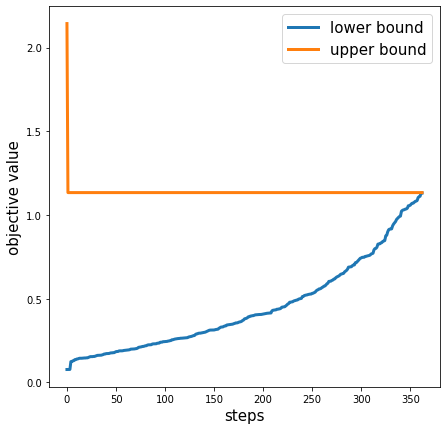

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(7,7))

plt.plot(lb_list, linewidth=3)
plt.plot(ub_list,linewidth=3)
plt.legend(['lower bound', 'upper bound'],fontsize=15)
plt.xlabel('steps', fontsize=15)
plt.ylabel('objective value', fontsize=15)
# plt.legend()



In [3]:
ub_list[-1]

1.1333549661755509

In [6]:
lb_list[-1]

1.1477903436651207

In [4]:
lb_list[-1]

1.1309250593398572

In [15]:
fig.savefig('conv.pdf')

In [8]:
Ns = [2, 4, 6] 
Ms = [4,8,12,16,32]
Ls = [2,4,6]

combinations = []

for N in Ns:
    for M in Ms:
        for max_ant in Ls:
            if max_ant < N:       
                combinations.append((N,M,max_ant))
combinations.append((8,12,6))

In [10]:
len(combinations)

16